# 1. Introduction

Nikki Satmaka
SI6-04

In [ ]:
# INI ADA PERUBAHAN

## Description

Dataset is sourced from [Kaggle](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset/code)

Context:
This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status.

Attribute Information
1. `id`: unique identifier
2. `gender`: "Male", "Female" or "Other"
3. `age`: age of the patient
4. `hypertension`: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5. `heart_disease`: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6. `ever_married`: "No" or "Yes"
7. `work_type`: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8. `Residence_type`: "Rural" or "Urban"
9. `avg_glucose_level`: average glucose level in blood
10. `bmi`: body mass index
11. `smoking_status`: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12. `stroke`: 1 if the patient had a stroke or 0 if not

*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

## Objective
- To create a model to predict `stroke`

## Problem Statement
- What features are going to be useful as predictors?
- Is there a relationship between heart disease and stroke?

# 2. Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV

from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

from sklearn.metrics import classification_report, confusion_matrix

pd.set_option("display.precision", 2)

# 3. Data Loading

In [ ]:
df_ori = pd.read_csv("/content/healthcare-dataset-stroke-data.csv")

df = df_ori.copy()

df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
df.tail()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0
5109,44679,Female,44.0,0,0,Yes,Govt_job,Urban,85.28,26.2,Unknown,0


## Data Understanding

In [ ]:
df.shape

(5110, 12)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [ ]:
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

## Basic Stats

In [ ]:
df.describe(percentiles=[0.5]).T

,count,mean,std,min,50%,max
id,5110.0,36517.83,21161.72,67.00,36932.00,72940.00
age,5110.0,43.23,22.61,0.08,45.00,82.00
hypertension,5110.0,0.10,0.30,0.00,0.00,1.00
heart_disease,5110.0,0.05,0.23,0.00,0.00,1.00
avg_glucose_level,5110.0,106.15,45.28,55.12,91.88,271.74
bmi,4909.0,28.89,7.85,10.30,28.10,97.60
stroke,5110.0,0.05,0.22,0.00,0.00,1.00


In [ ]:
df.describe(include="O").T

,count,unique,top,freq
gender,5110,3,Female,2994
ever_married,5110,2,Yes,3353
work_type,5110,5,Private,2925
Residence_type,5110,2,Urban,2596
smoking_status,5110,4,never smoked,1892


In [ ]:
for col in df.select_dtypes("O").columns:
    print(f"{col}: {df[col].unique()}")

gender: ['Male' 'Female' 'Other']
ever_married: ['Yes' 'No']
work_type: ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type: ['Urban' 'Rural']
smoking_status: ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


- `smoking_status`
    - Nominal feature
    - 4 unique values
    - the value 'Unknown' are actually missing values
- `gender`
    - Nominal feature
    - 2 unique values
- `age`
    - Numerical feature
    - Normal distribution


## Missing values

In [ ]:
df["smoking_status"].value_counts() / df.shape[0]

smoking_status
never smoked       0.37
Unknown            0.30
formerly smoked    0.17
smokes             0.15
Name: count, dtype: float64

Since the value `Unknown` is considered as missing value, that means there are 30% of missing values in the `smoking_status` feature. We will decide how to deal with it after EDA

## Check for Dataset Imbalance

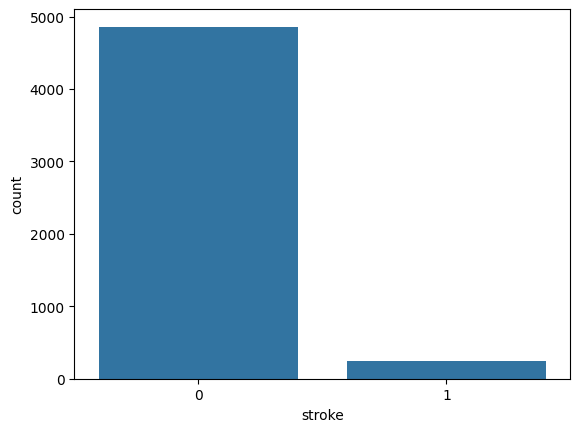

In [ ]:
sns.countplot(data=df, x="stroke")

plt.show()

In [ ]:
df.stroke.value_counts()

stroke
0    4861
1     249
Name: count, dtype: int64

The dataset is very imbalanced with a ratio of 20:1
That means, we will have to stratify when splitting and we will perform oversampling


## Splitting Dataset

### Sampling for inference

In [ ]:
df_train_test, df_inf = train_test_split(df, test_size=10, random_state=42, stratify=df["stroke"])

print(df_inf.shape)

(10, 12)


### Split train and test

In [ ]:
df_train, df_test = train_test_split(df_train_test, test_size=0.2, random_state=42, stratify=df_train_test["stroke"])

print(df_train.shape)
print(df_test.shape)

(4080, 12)
(1020, 12)


In [ ]:
df_train_ori = df_train.copy()

# 4. Exploratory Data Analysis

In [ ]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### Number of patients according to their gender

<Axes: xlabel='gender', ylabel='count'>

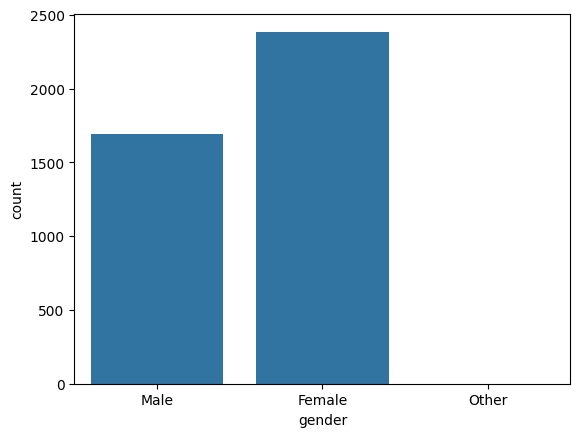

In [ ]:
sns.countplot(data=df_train, x="gender")

There are more female patients compared to male patients

## Hypertension

<Axes: xlabel='hypertension', ylabel='count'>

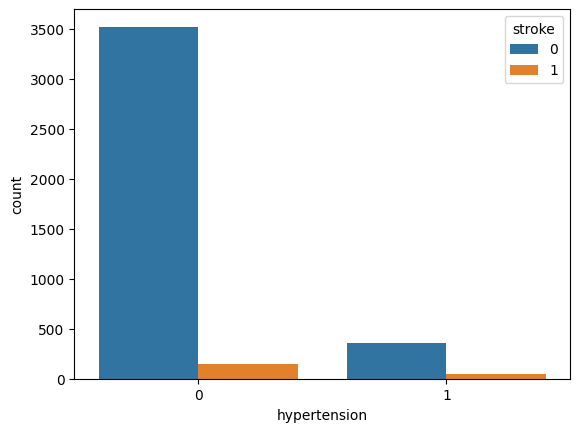

In [ ]:
sns.countplot(data=df_train, x="hypertension", hue="stroke")

In [ ]:
df_train.groupby(["hypertension", "stroke"])["id"].count()

hypertension  stroke
0             0         3523
              1          151
1             0          358
              1           48
Name: id, dtype: int64

In [ ]:
# - people who have stroke, without hypertension: 151
# - people without hypertension: 151 + 3523
# - people who have stroke, with hypertension: 48
# - people with hypertension: 48 + 358

print("percentage of people who have stroke, without hypertension:", np.round(151/(151+3523), 2))
print("percentage of people who have stroke, with hypertension:", np.round(48/(48+358), 2))

percentage of people who have stroke, without hypertension: 0.04
percentage of people who have stroke, with hypertension: 0.12


There is about 3x more patients who got stroke for patients who have hypertension, compared to patients without hypertension

## Age and Stroke

<Axes: ylabel='age'>

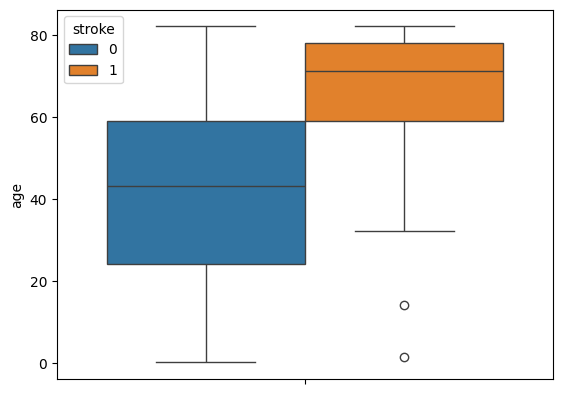

In [ ]:
#korelasi umur dan stroke
sns.boxplot(data=df, orient='v', y='age', hue='stroke')

<Axes: xlabel='age', ylabel='Density'>

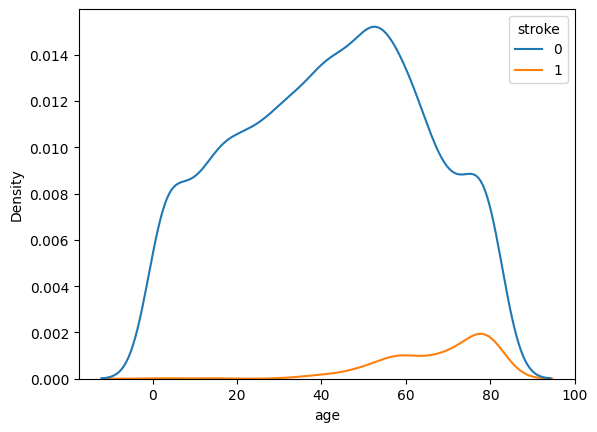

In [ ]:
#pkorelasi umur dan stroke
sns.kdeplot(df, x='age', hue='stroke')

The majority of people who got stroke is between 60 - 80 years old. However, there are outlier cases where patients under 20 years old got stroke

# 5. Data Preprocessing

In [ ]:
df_train = df_train_ori.copy()

## Handling outliers

In [ ]:
X_train = df_train.drop(["stroke"], axis=1)
y_train = df_train["stroke"].copy()

X_test = df_test.drop(["stroke"], axis=1)
y_test = df_test["stroke"].copy()

In [ ]:
num_cols = ["age", "avg_glucose_level", "bmi"]
nom_cols = ["gender", "hypertension", "heart_disease", "ever_married", "work_type", "Residence_type", "smoking_status"]

In [ ]:
X_train[num_cols]

,age,avg_glucose_level,bmi
4753,56.0,139.87,31.2
3055,62.0,67.07,24.5
3567,33.0,75.67,44.7
2914,56.0,102.97,NaN
289,59.0,117.92,29.4
...,...,...,...
3735,69.0,103.73,34.7
946,47.0,204.63,43.4
2710,64.0,190.92,31.4
4574,33.0,85.27,25.8


In [ ]:
X_train[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
age,4080.0,43.29,22.41,0.16,25.00,45.00,61.00,82.00
avg_glucose_level,4080.0,106.40,45.75,55.12,77.22,91.81,114.11,271.74
bmi,3920.0,28.93,7.82,10.30,23.50,28.00,33.10,92.00


In [ ]:
X_train_capped = X_train.copy()
for col in ["avg_glucose_level", "bmi"]:
    q1 = X_train_capped[col].quantile(0.25)
    q3 = X_train_capped[col].quantile(0.75)
    iqr = q3 - q1
    upper_limit = q3 + 1.5 * iqr
    lower_limit = q1 - 1.5 * iqr
    X_train_capped[col] = np.where(X_train_capped[col] > upper_limit, upper_limit, X_train_capped[col])
    X_train_capped[col] = np.where(X_train_capped[col] < lower_limit, lower_limit, X_train_capped[col])

In [ ]:
X_train.shape

(4080, 11)

In [ ]:
X_train_capped.shape

(4080, 11)

<Axes: xlabel='bmi'>

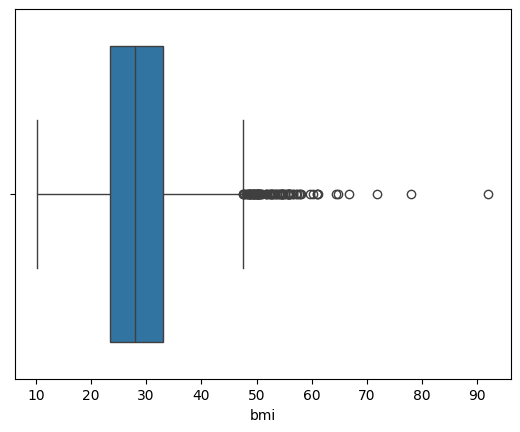

In [ ]:
sns.boxplot(data=X_train, x="bmi")

<Axes: xlabel='bmi'>

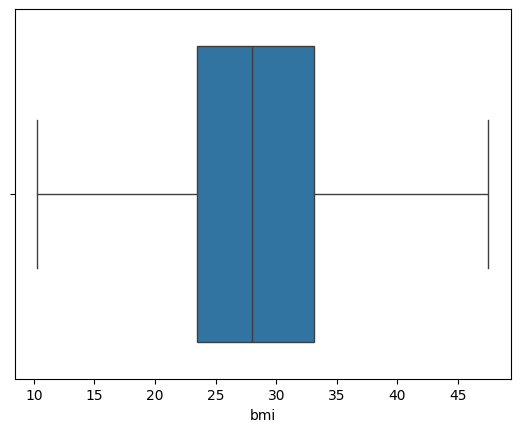

In [ ]:
sns.boxplot(data=X_train_capped, x="bmi")

## Handling missing values

In [ ]:
def impute_stroke(df):
    df["bmi"] = df["bmi"].fillna(df["bmi"].median())
    df["smoking_status"] = np.where(df["smoking_status"] == "Unknown", "never smoked", df["smoking_status"])
    return df

X_train_imputed = impute_stroke(X_train_capped)
X_test_imputed = impute_stroke(X_test)

In [ ]:
X_train_imputed.smoking_status.value_counts()

smoking_status
never smoked       2741
formerly smoked     704
smokes              635
Name: count, dtype: int64

## Feature Selection

<Axes: >

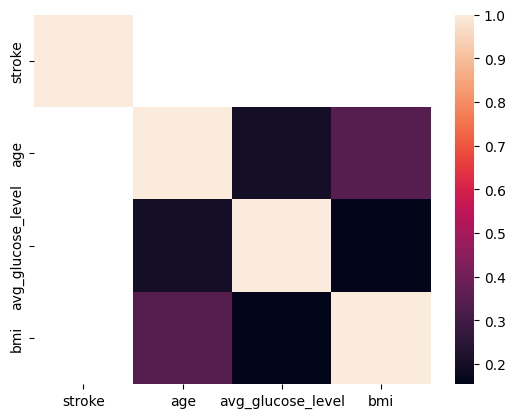

In [ ]:
sns.heatmap(pd.concat([pd.DataFrame(y_train), X_train_imputed[num_cols]]).corr())

## Feature Engineering

In [ ]:
std_sc = StandardScaler()
ohe_enc = OneHotEncoder(handle_unknown="ignore")

In [ ]:
scale = ColumnTransformer([
    ("num", std_sc, num_cols),
    ("nom", "passthrough", nom_cols),
])

encode = ColumnTransformer([
    ("num", "passthrough", slice(0, 3)),
    ("nom", ohe_enc, slice(3, 10)),
])

smotenc = SMOTENC(
    categorical_features=list(range(3, 10)),
    random_state=42
)

## Scaling

In [ ]:
X_train_scaled = scale.fit_transform(X_train_imputed)
X_test_scaled = scale.transform(X_test_imputed)

## Oversampling

In [ ]:
X_train_oversampled, y_train_oversampled = smotenc.fit_resample(X_train_scaled, y_train)

In [ ]:
print(X_train_oversampled.shape)
print(y_train_oversampled.shape)

(7762, 10)
(7762,)


<Axes: xlabel='stroke', ylabel='count'>

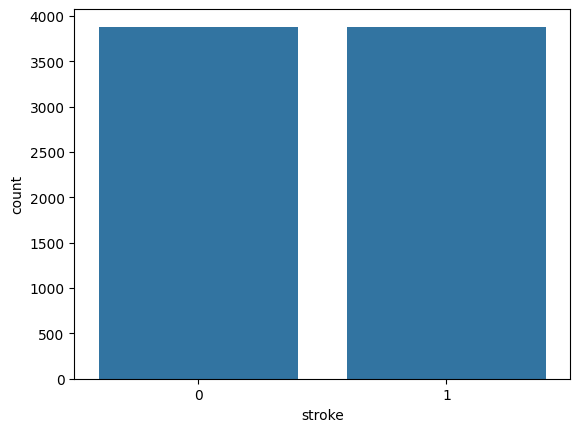

In [ ]:
sns.countplot(pd.DataFrame(y_train_oversampled), x="stroke")

## Encoding

In [ ]:
X_train_encoded = encode.fit_transform(X_train_oversampled)
X_test_encoded = encode.transform(X_test_scaled)

# 6. Modeling

Target: Predicting whether patients are likely to get stroke

Metrics:
Since the target we are predicting is a stroke, which is in the medical area, we want to minimize the False Negative results, since the risk would be more catastrophical to the patients
Hence, we will focus more on recall as our main metrics

Predictors:
- Numerical:
    - ['age', 'avg_glucose_level', 'bmi']
- Categorical:
    - ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

Models:
- Decision Tree
- Random Forest
- XGB

In [ ]:
dt = DecisionTreeClassifier(random_state=42)

rf = RandomForestClassifier(random_state=42)

xgb = XGBClassifier(random_state=42)

# 7. Model Training

In [ ]:
# decision tree
dt.fit(X_train_encoded, y_train_oversampled)
dt_score = cross_validate(dt, X_train_encoded, y_train_oversampled, scoring=["accuracy", "recall", "f1"], cv=3)


# random forest
rf.fit(X_train_encoded, y_train_oversampled)
rf_score = cross_validate(rf, X_train_encoded, y_train_oversampled, scoring=["accuracy", "recall", "f1"], cv=3)

# xgboost
xgb.fit(X_train_encoded, y_train_oversampled)
xgb_score = cross_validate(xgb, X_train_encoded, y_train_oversampled, scoring=["accuracy", "recall", "f1"], cv=3)

# 8. Model Evaluation

In [ ]:
dt_score

{'fit_time': array([0.04340243, 0.08300734, 0.09625506]),
 'score_time': array([0.01474285, 0.02515554, 0.03088355]),
 'test_accuracy': array([0.87751159, 0.90104368, 0.90181678]),
 'test_recall': array([0.85239567, 0.93890178, 0.91808346]),
 'test_f1': array([0.87435593, 0.90461997, 0.90342205])}

In [ ]:
rf_score

{'fit_time': array([1.18108654, 1.62809515, 1.17397332]),
 'score_time': array([0.14886808, 0.16624618, 0.0694592 ]),
 'test_accuracy': array([0.91692427, 0.9373792 , 0.94317743]),
 'test_recall': array([0.9049459, 0.9675174, 0.9675425]),
 'test_f1': array([0.91591709, 0.93918919, 0.94454923])}

In [ ]:
xgb_score

{'fit_time': array([0.12034202, 0.12549019, 0.12441778]),
 'score_time': array([0.02023411, 0.01606107, 0.01624751]),
 'test_accuracy': array([0.92156105, 0.93467337, 0.94472362]),
 'test_recall': array([0.9057187 , 0.97370456, 0.96445131]),
 'test_f1': array([0.92029839, 0.93710458, 0.94581281])}

- Based on the evaluation, we can see that the recall score of random forest is better than the recall score of decision tree
- In this case, since the random forest is the original model that is asked for the assignment, I'm gonna choose random forest as the main algorithm to bu tuned

## Hyperparameter Tuning

In [ ]:
param_grid = {
   "min_samples_leaf": [1, 3, 5, 7, 9],
   "max_depth": [None, 3, 5, 7],
   "n_estimators": [10, 100],
   "criterion": ["gini", "entropy", "log_loss"]
}

In [ ]:
grid = GridSearchCV(rf, param_grid=param_grid, scoring="recall", cv=3)

In [ ]:
grid.fit(X_train_encoded, y_train_oversampled)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [None, 3, 5, 7],
                         'min_samples_leaf': [1, 3, 5, 7, 9],
                         'n_estimators': [10, 100]},
             scoring='recall')

In [ ]:
grid.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'min_samples_leaf': 3,
 'n_estimators': 100}

In [ ]:
grid.best_score_

0.9479558021176127

In [ ]:
grid.best_estimator_

RandomForestClassifier(criterion='entropy', min_samples_leaf=3, random_state=42)

In [ ]:
rf_tuned = grid.best_estimator_

## Evaluate Hyperparameter Tuning Results

In [ ]:
y_pred_train_rf_tuned = rf_tuned.predict(X_train_encoded)
y_pred_test_rf_tuned = rf_tuned.predict(X_test_encoded)

y_pred_train_rf = rf.predict(X_train_encoded)
y_pred_test_rf = rf.predict(X_test_encoded)

In [ ]:
print("train non tuning")
print(classification_report(y_train_oversampled, y_pred_train_rf))
print("test non tuning")
print(classification_report(y_test, y_pred_test_rf))

print("train tuning")
print(classification_report(y_train_oversampled, y_pred_train_rf_tuned))
print("test tuning")
print(classification_report(y_test, y_pred_test_rf_tuned))

train non tuning
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3881
           1       1.00      1.00      1.00      3881

    accuracy                           1.00      7762
   macro avg       1.00      1.00      1.00      7762
weighted avg       1.00      1.00      1.00      7762

test non tuning
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       970
           1       0.09      0.16      0.12        50

    accuracy                           0.88      1020
   macro avg       0.52      0.54      0.53      1020
weighted avg       0.91      0.88      0.90      1020

train tuning
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      3881
           1       0.96      0.98      0.97      3881

    accuracy                           0.97      7762
   macro avg       0.97      0.97      0.97      7762
weighted avg       0.97     

In [ ]:
print("train non tuning")
print(confusion_matrix(y_train_oversampled, y_pred_train_rf))
print("test non tuning")
print(confusion_matrix(y_test, y_pred_test_rf))
print("train tuning")
print(confusion_matrix(y_train_oversampled, y_pred_train_rf_tuned))
print("test tuning")
print(confusion_matrix(y_test, y_pred_test_rf_tuned))

train non tuning
[[3881    0]
 [   0 3881]]
test non tuning
[[892  78]
 [ 42   8]]
train tuning
[[3736  145]
 [  71 3810]]
test tuning
[[884  86]
 [ 41   9]]


- We can now see that the recall score after tuning is 0.18, which is better compared to the non tuned one, at 0.16
- However, this score is still low, as we want to minimize the FN as much as possible. Therefore much improvement is needed on this case

## Save the final Model

In [ ]:
# pipeline
# scale data inference
# encode data inference
# predict data inference

rf_pipeline = Pipeline([
    ("scale", scale),
    ("encode", encode),
    ("rf_tuned", rf_tuned)
])


In [ ]:
joblib.dump(impute_stroke, "/content/stroke_imputer.pkl")
joblib.dump(rf_pipeline, "/content/rf_tuned_pipe.pkl")

['/content/rf_tuned_pipe.pkl']

# 9. Model Inference

## Load model

In [ ]:
imputer = joblib.load("/content/stroke_imputer.pkl")
model = joblib.load("/content/rf_tuned_pipe.pkl")

## Inferencing

In [ ]:
df_inf.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3341,51762,Female,59.00,0,0,Yes,Private,Rural,134.24,28.8,Unknown,0
3168,19436,Male,56.00,0,0,Yes,Private,Rural,82.40,30.9,smokes,0
4675,53095,Male,8.00,0,0,No,children,Rural,63.43,21.8,Unknown,0
1109,32240,Female,27.00,0,0,No,Private,Urban,93.55,41.6,never smoked,0
4021,8247,Male,0.16,0,0,No,children,Urban,109.52,13.9,Unknown,0


In [ ]:
df_inf_final = df_inf.drop(["id", "stroke"], axis=1)
df_inf_final = imputer(df_inf_final)

df_inf_final.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
3341,Female,59.00,0,0,Yes,Private,Rural,134.24,28.8,never smoked
3168,Male,56.00,0,0,Yes,Private,Rural,82.40,30.9,smokes
4675,Male,8.00,0,0,No,children,Rural,63.43,21.8,never smoked
1109,Female,27.00,0,0,No,Private,Urban,93.55,41.6,never smoked
4021,Male,0.16,0,0,No,children,Urban,109.52,13.9,never smoked


In [ ]:
y_pred_inf = model.predict(df_inf_final)

df_inf_final["pred"] = y_pred_inf

df_inf_final.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,pred
3341,Female,59.00,0,0,Yes,Private,Rural,134.24,28.8,never smoked,0
3168,Male,56.00,0,0,Yes,Private,Rural,82.40,30.9,smokes,1
4675,Male,8.00,0,0,No,children,Rural,63.43,21.8,never smoked,0
1109,Female,27.00,0,0,No,Private,Urban,93.55,41.6,never smoked,0
4021,Male,0.16,0,0,No,children,Urban,109.52,13.9,never smoked,0


# 10. Conclusion

Improvement
- when imputing the smoking_status feature, we should come up with a better idea
- collect more data